In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt

from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

    # Test if WordNet and stopwords are accessible
print(wn.synsets('dog'))  # Should return a list of Synsets
print(stopwords.words('english')[:5])  # Should return a list of stopwords


# Initialize WordNetLemmatizer
wl = WordNetLemmatizer()

# Load stopwords
stopwords = nltk.corpus.stopwords.words('english')


[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [2]:
def preprocess_cluster(document, wl, stopwords):
    """ Basic preprocessing of documents. """
    # Remove line breaks, tabs, and special characters
    cleaned_document = document.replace("\n", " ").replace("\t", " ")
    cleaned_document = re.sub(r'[^A-Za-z0-9 ]+', '', cleaned_document)
    # Convert to lower case and remove punctuation
    cleaned_document = ''.join([char.lower() for char in cleaned_document if char not in string.punctuation])
    # Tokenize and lemmatize
    tokens = re.split('\W+', cleaned_document)
    tokens = [wl.lemmatize(word) for word in tokens if word not in stopwords]
    return ' '.join(tokens)

# Load the dataset
df = pd.read_csv('/kaggle/input/clustered-data/clustered_arxiv_db.csv')

# Preprocess titles and abstracts
df['processed_title'] = df['title'].apply(lambda x: preprocess_cluster(x, wl, stopwords))
df['processed_abstract'] = df['abstract'].apply(lambda x: preprocess_cluster(x, wl, stopwords))

# Combine processed title and abstract for topic modeling
df['cand_topics'] = df['processed_title'] + ' ' + df['processed_abstract']


In [3]:
# Vectorize the text data using CountVectorizer with limited features
vectorizer = CountVectorizer(max_features=500)  # Limit to 500 features for simplification
x = vectorizer.fit_transform(df['cand_topics'])
x_normalized = normalize(x, norm='l1', axis=1)
bag_df = pd.DataFrame(x_normalized.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate TF-IDF for each word in each cluster with limited features
tfidf_vect = TfidfVectorizer(norm='l1', max_features=500)  # Limit to 500 features
x_tfidf = tfidf_vect.fit_transform(df['cand_topics'])
x_tfidf_normalized = normalize(x_tfidf, norm='l1', axis=1)
x_tfidf_df = pd.DataFrame(x_tfidf_normalized.toarray(), columns=tfidf_vect.get_feature_names_out())

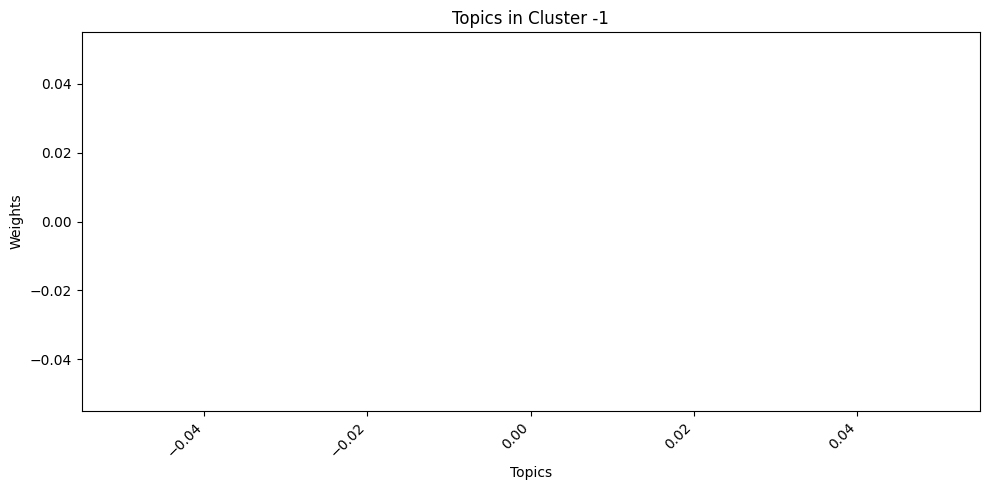

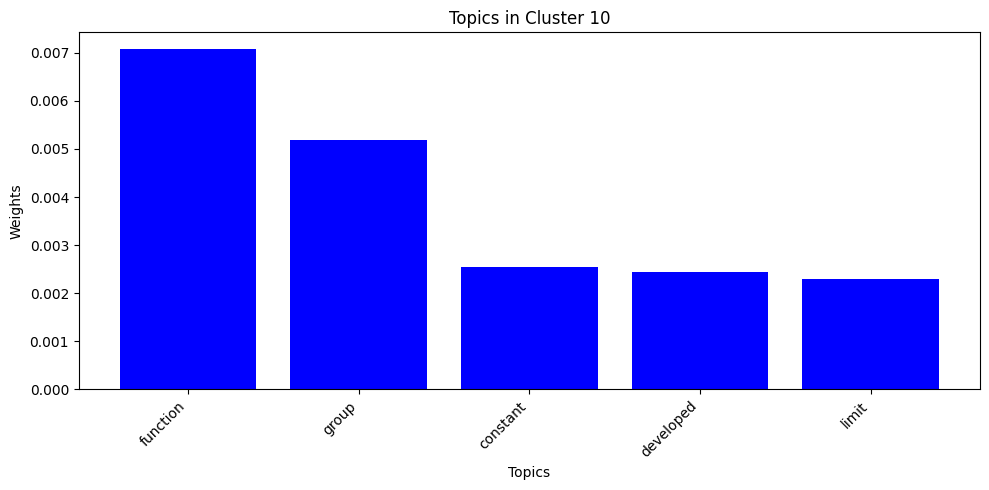

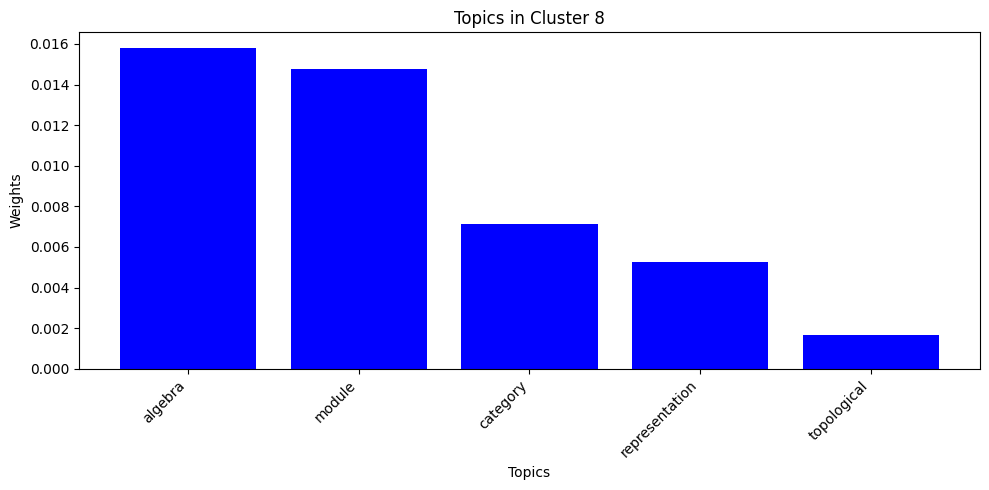

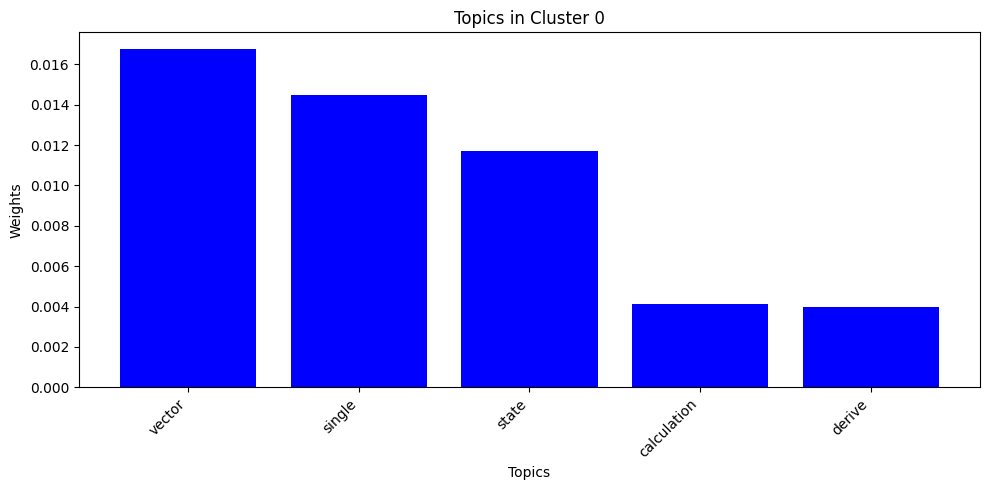

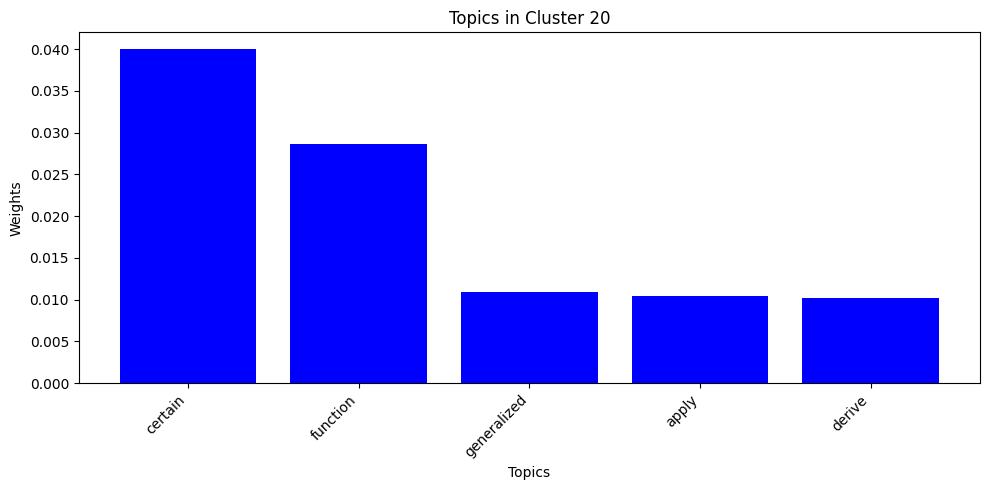

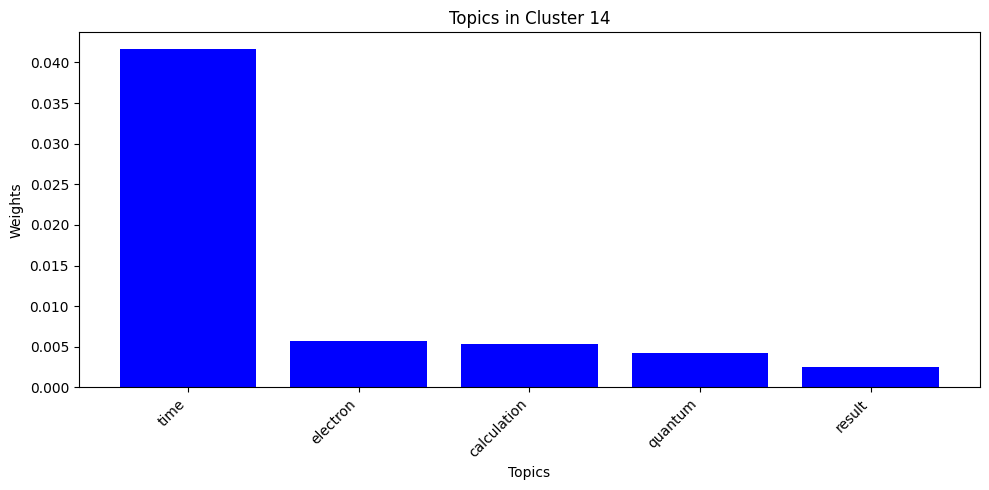

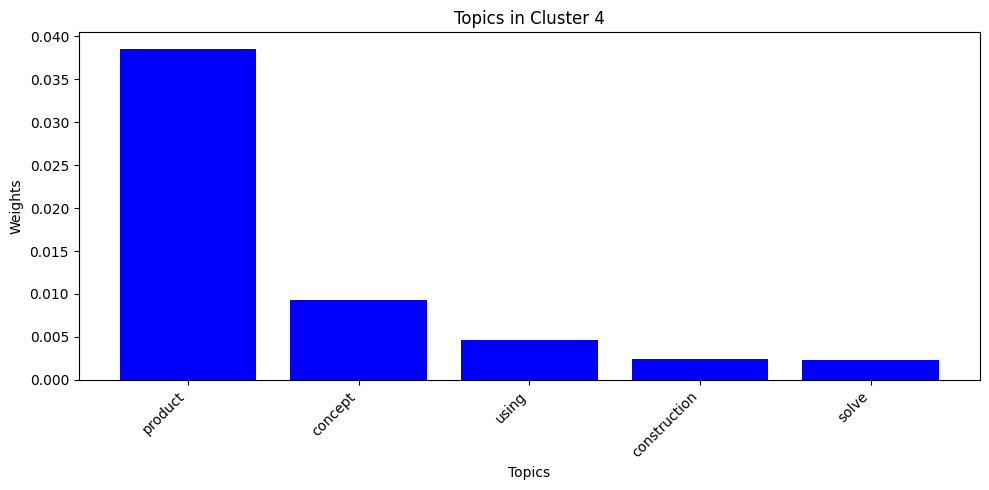

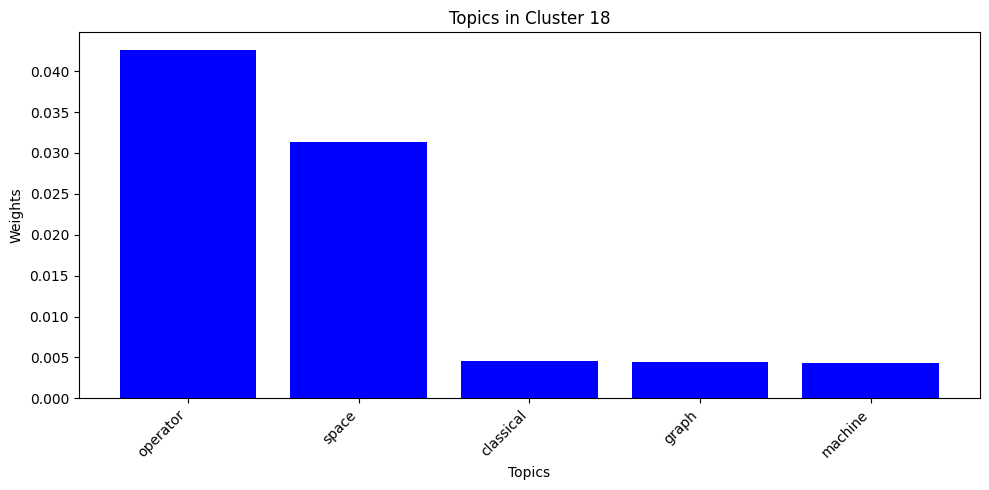

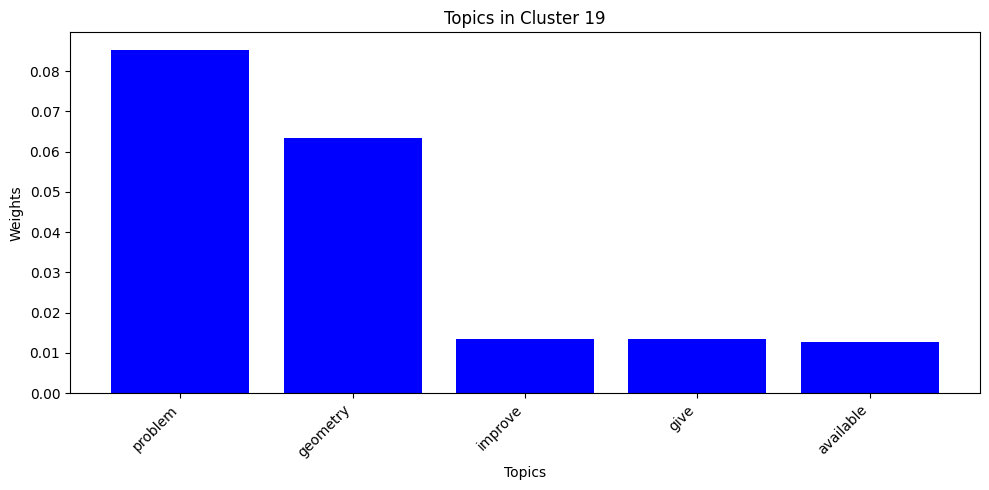

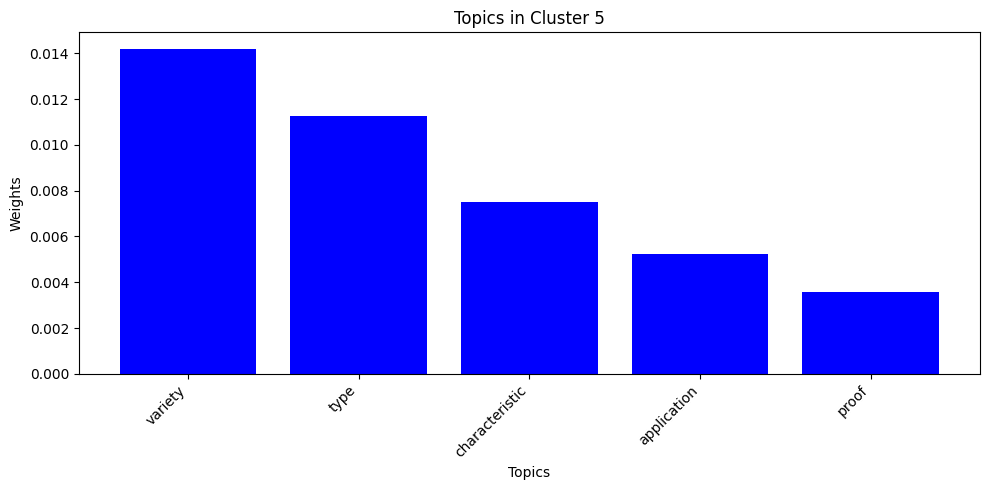

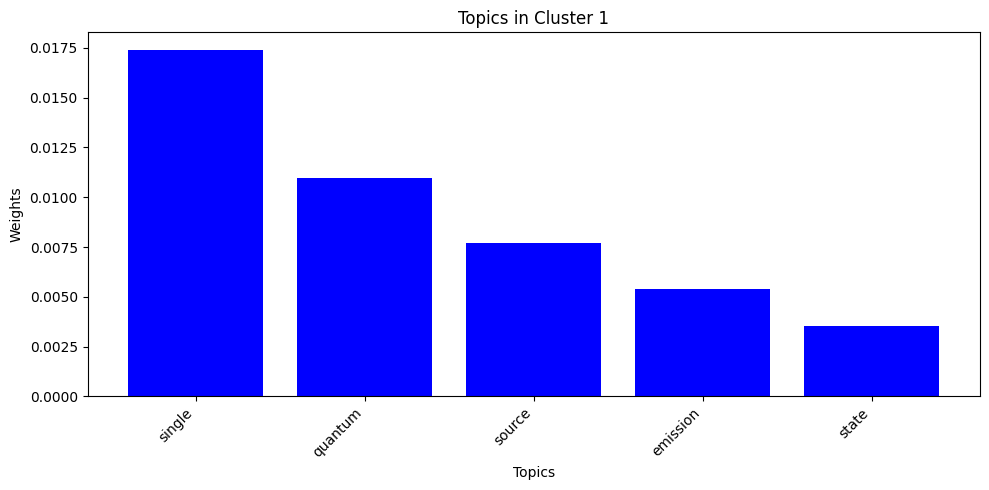

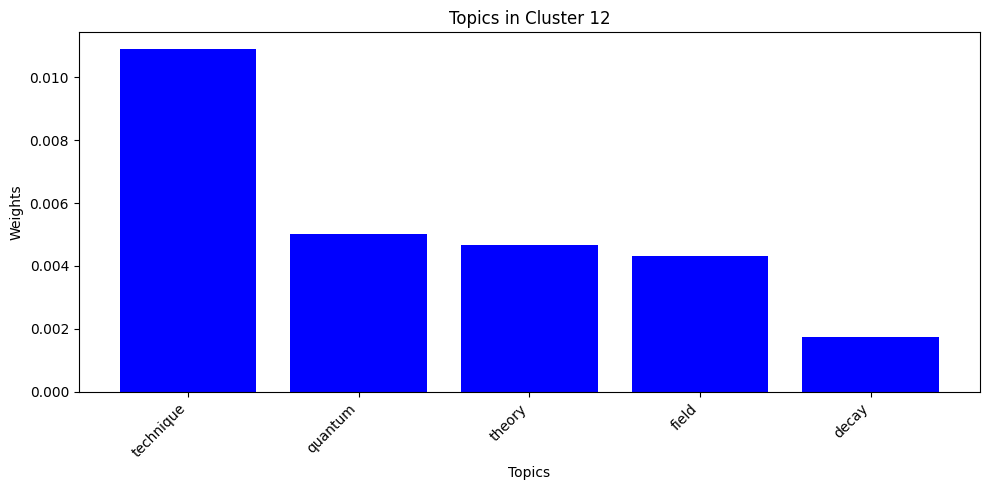

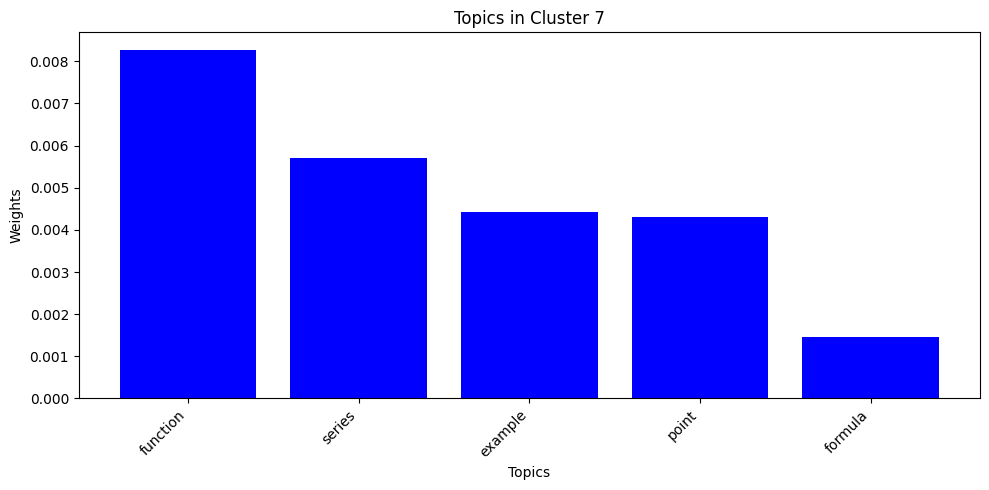

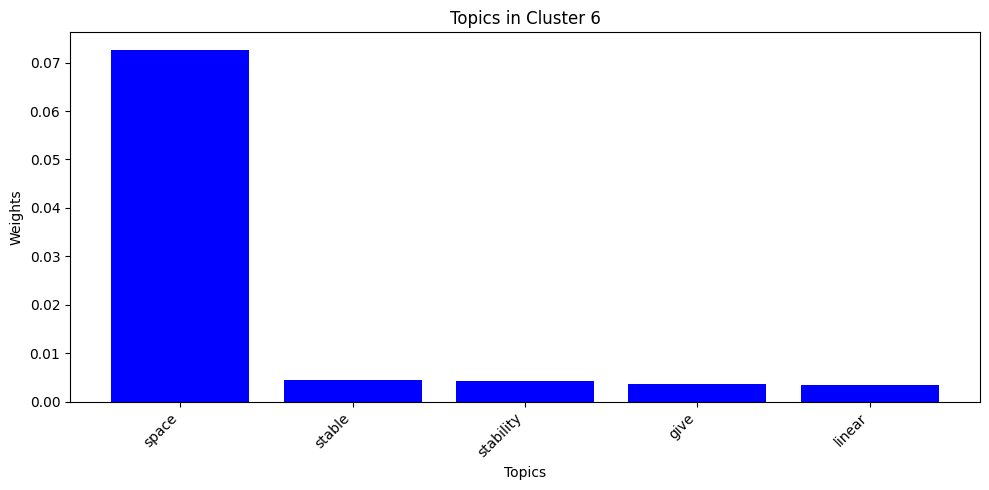

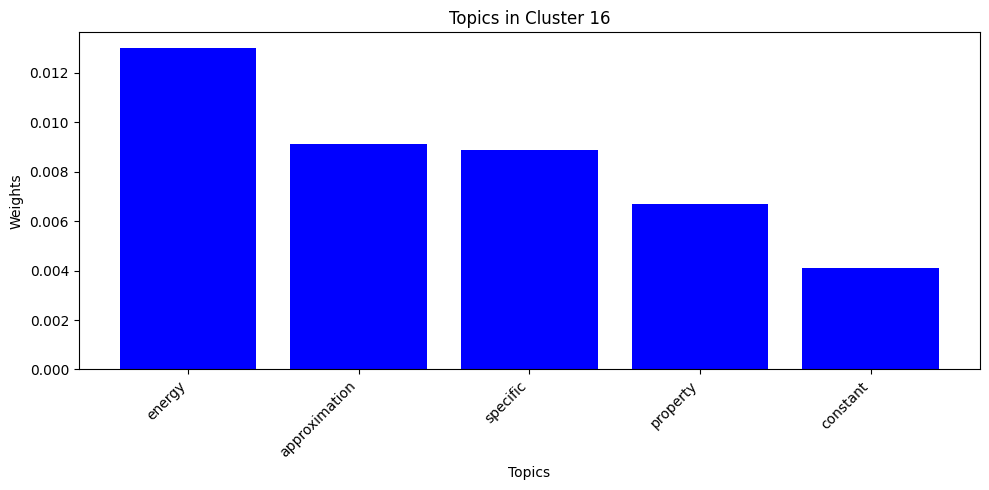

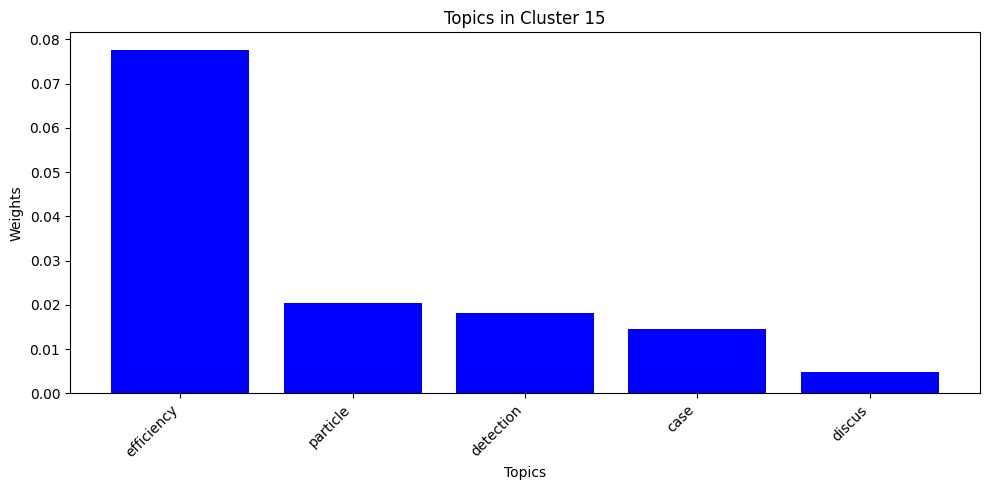

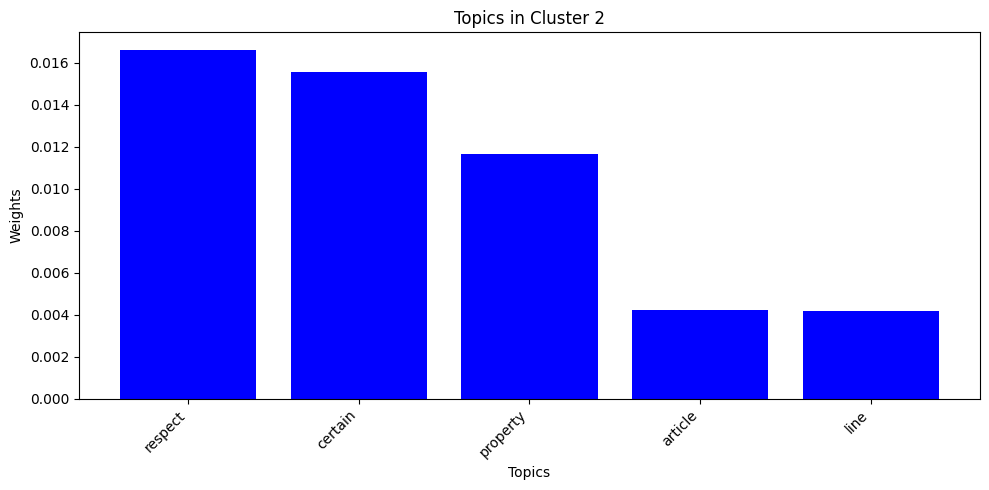

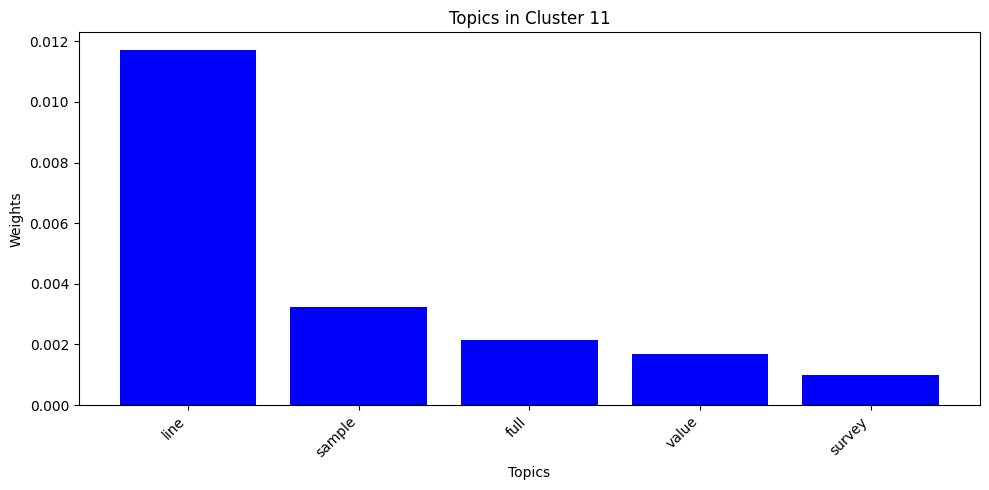

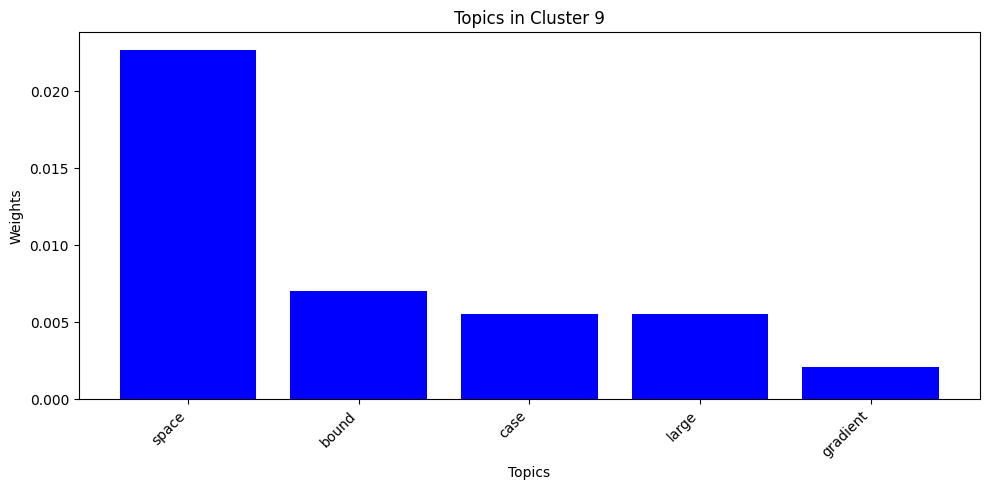

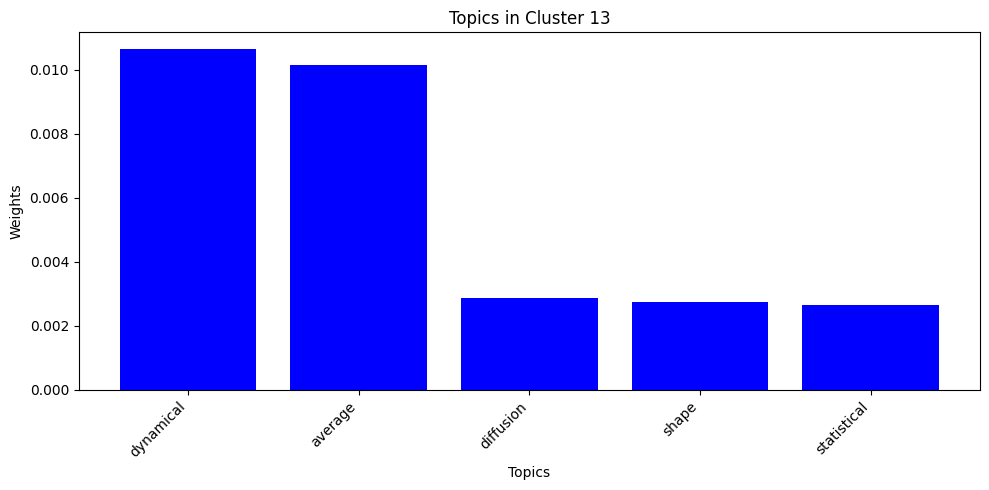

In [4]:
def get_topics(df_main, df_clus):
    topics = {}
    weights = {}
    # Iterate through unique clusters
    for index in df_clus.index.unique():
        # Multiply count vector with tfidf vector to get weighted importance
        topics_weights = df_main.loc[index].multiply(df_clus.loc[index])
        # Sort and select top 5 topics for simplification
        sorted_topics = topics_weights.sort_values(ascending=False).head(5)
        topics[index] = sorted_topics.index.tolist()
        weights[index] = sorted_topics.values.tolist()
    return topics, weights

# Extract topics and their weights
topics, weights = get_topics(bag_df, x_tfidf_df)

# Compile final DataFrame with topic information
df_final = pd.concat([df.groupby('hdbscan_cluster').size().rename('count'), pd.Series(topics, name='topics'), pd.Series(weights, name='weights')], axis=1)
df_final['cluster_size'] = df_final['count'] / df_final['count'].sum()

# Number of clusters to display
top_n_clusters = 20  # or any other number you prefer

# Sort clusters by their size and select the top N clusters
top_clusters = df_final.sort_values(by='count', ascending=False).head(top_n_clusters).index

# Iterate through each of the top clusters to create a bar chart
for cluster in top_clusters:
    # Extract topics and their weights for the current cluster
    cluster_topics = df_final.at[cluster, 'topics']
    cluster_weights = df_final.at[cluster, 'weights']

    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.bar(cluster_topics, cluster_weights, color='blue')
    plt.xlabel('Topics')
    plt.ylabel('Weights')
    plt.title(f'Topics in Cluster {cluster}')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

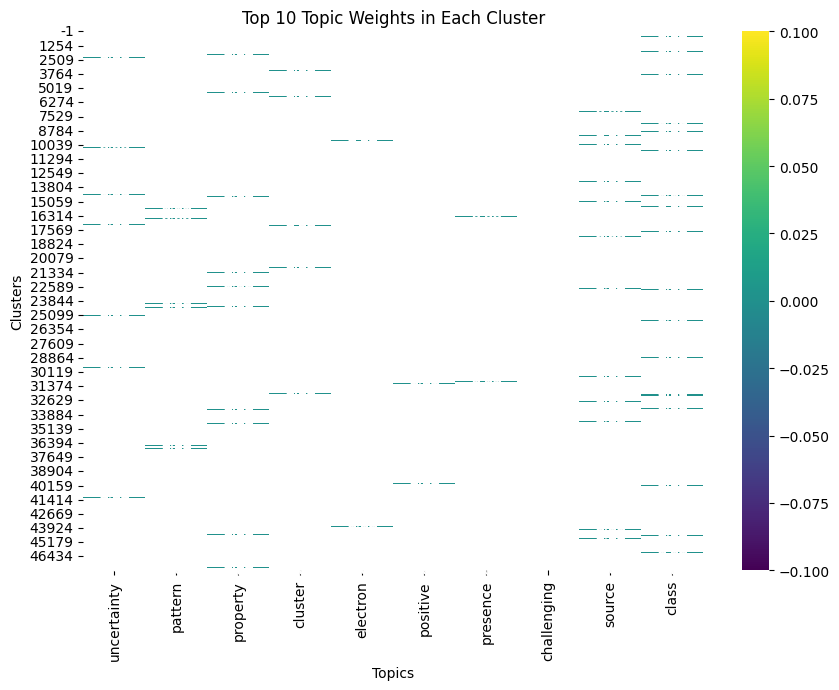

In [5]:
# Ensure all entries in 'topics' are lists
df_final['topics'] = df_final['topics'].apply(lambda x: x if isinstance(x, list) else [])

# Create a set of unique topics
unique_topics = set(sum(df_final['topics'].tolist(), []))

# Convert the set of unique topics to a list
unique_topics_list = list(unique_topics)

# Create a new DataFrame to store topic weights for each cluster
topic_matrix = pd.DataFrame(index=df_final.index, columns=unique_topics_list)

# Populate the matrix with weights
for cluster in df_final.index:
    for topic in unique_topics_list:
        if topic in df_final.at[cluster, 'topics']:
            topic_index = df_final.at[cluster, 'topics'].index(topic)
            topic_weight = df_final.at[cluster, 'weights'][topic_index]
            if isinstance(topic_weight, list) and len(topic_weight) > 0:
                topic_matrix.at[cluster, topic] = topic_weight[0]
            else:
                topic_matrix.at[cluster, topic] = 0

# Convert the elements in topic_matrix to float
topic_matrix = topic_matrix.astype(float)

# Sort topics by weights and select the top 10
# Create a dictionary to store the maximum weights for each topic
topic_max_weights = {}

# Iterate through unique topics and find their maximum weights
for topic in unique_topics_list:
    max_weight = df_final['weights'].apply(lambda x: x[0] if isinstance(x, list) and topic in x else 0).max()
    topic_max_weights[topic] = max_weight

# Sort topics by their maximum weights and select the top 10
top_10_topics = sorted(unique_topics_list, key=lambda topic: topic_max_weights[topic], reverse=True)[:10]

# Create a new DataFrame to store topic weights for each cluster
topic_matrix = pd.DataFrame(index=df_final.index, columns=top_10_topics)

# Populate the matrix with weights for the top 10 topics
for cluster in df_final.index:
    for topic in top_10_topics:
        if topic in df_final.at[cluster, 'topics']:
            topic_index = df_final.at[cluster, 'topics'].index(topic)
            topic_weight = df_final.at[cluster, 'weights'][topic_index]
            if isinstance(topic_weight, list) and len(topic_weight) > 0:
                topic_matrix.at[cluster, topic] = topic_weight[0]
            else:
                topic_matrix.at[cluster, topic] = 0

# Convert the elements in the topic_matrix to float
topic_matrix = topic_matrix.astype(float)

# Plotting the heatmap for the top 10 topics
plt.figure(figsize=(10, 7))  # Adjust the figure size as needed
sns.heatmap(topic_matrix, cmap='viridis', annot=True, fmt=".2f")
plt.title('Top 10 Topic Weights in Each Cluster')
plt.xlabel('Topics')
plt.ylabel('Clusters')
plt.show()
